# item-based 최근접 이웃 협업 필터링 실습

In [4]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/ml-latest-small')

In [6]:
movies = pd.read_csv('movies.csv', encoding='utf-8')
ratings = pd.read_csv('ratings.csv', encoding='utf-8')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
# moviesId를 key로 하여 두개의 데이터프레임 merge하기
# 필요없는 칼럼인 timestamp 삭제
ratings = ratings.drop('timestamp', axis=1)

In [12]:
# ratings 테이블을 pivot_table이용해서 user-item 데이터셋으로 변경
# pivot_table(values, index, columns)
ratings_matrix = ratings.pivot_table(values='rating', index='userId',
                   columns='movieId')
ratings_matrix.head(2)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# ratings_matrix의 칼럼인 movieId를 텍스트인 영화이름으로 가져오기 위해서
# movies 데이터의 title칼럼 사용하자!
# 그러기 위해서 우선 두개의 데이터프레임을 merge하자
rating_movies = pd.merge(ratings, movies, on='movieId')

# 다시 pivot_table이용해서 user-item 데이터셋으로 만들기
rating_movies_matrix = rating_movies.pivot_table(values='rating',
                                                index='userId',
                                                columns='title')
# 결측치 값을 모두 0으로 채우기(평점이 매겨지지 않은 것임!)
rating_movies_matrix = rating_movies_matrix.fillna(0)
rating_movies_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# 이제 user-item기반 데이터셋을 만들었으니까 item(영화들)간의 유사도 산출
# 코사인 유사도 이용
# 우선 user-item 에서 item-user 데이터셋으로 변환하기 위해 Transpose()
rating_movies_matrix_T = rating_movies_matrix.transpose()
rating_movies_matrix_T.head(2)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# sklearn을 이용해서 코사인 유사도 도출
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 측정할 때, 매트릭스의 행 vector끼리 유사도 비교!
item_sim = cosine_similarity(rating_movies_matrix_T,
                            rating_movies_matrix_T)

# 코사인 유사도 행렬의 칼럼, 인덱스값을 item(영화)이름을 넣어서 데이터프레임 생성
item_sim_df = pd.DataFrame(item_sim, index=rating_movies_matrix.columns,
                          columns=rating_movies_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head()

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Salem's Lot (2004),0.0,0.000000,0.000000,1.000000,0.857493,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Til There Was You (1997),0.0,0.000000,0.000000,0.857493,1.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


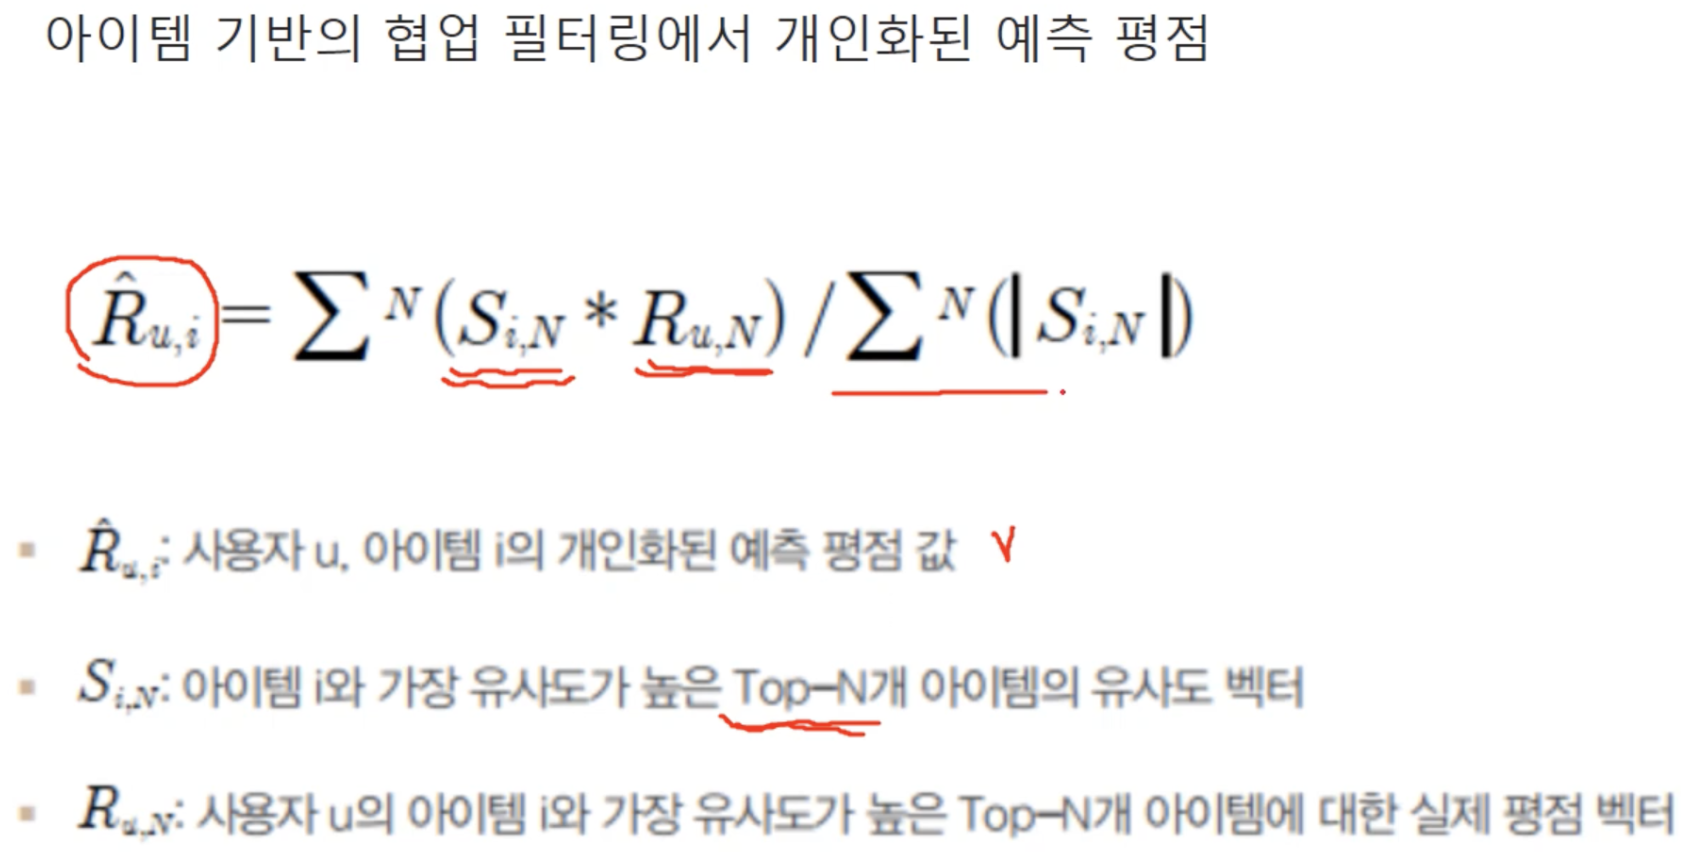

In [19]:
# 이제 개인화된 영화 추천을 하기 위해서 Weighted Rating Sum 생성(공식 이용)
from IPython.display import Image
Image('/Users/younghun/Desktop/영훈/weighted_sum.png')

In [39]:
def predict_rating(ratings_arr, item_sim_arr):
    # 2차원 array로 만들어야 하므로 분모에 np.abs를 하나의 array안에 담아주자!
    ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [46]:
# 개인화 평점 계산해서 user-item 데이터셋으로 만들기
ratings_pred = predict_rating(rating_movies_matrix.values,
                             item_sim_df.values)
rating_pred_df = pd.DataFrame(ratings_pred,
                                 index=rating_movies_matrix.index,
                                 columns=rating_movies_matrix.columns)

In [50]:
print(rating_pred_df.shape)
rating_pred_df.head()

(610, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501
4,0.049145,0.277628,0.160448,0.206892,0.309632,0.042337,0.130048,0.116442,0.099785,0.097432,...,0.051269,0.076051,0.055563,0.054137,0.008343,0.159242,0.100941,0.062253,0.146054,0.231187
5,0.007278,0.066951,0.041879,0.013880,0.024842,0.018240,0.026405,0.018673,0.021591,0.018841,...,0.009689,0.022246,0.013360,0.012378,0.000000,0.025839,0.023712,0.018012,0.028133,0.052315


In [63]:
# 그러면 user가 각 item(영화)에 대해 평가한 실제 rating과 계산된 개인화된 rating값의 오차를 비교해보자.
from sklearn.metrics import mean_squared_error

# np.nonzero()는 0이 아닌 값을 갖는 요소의 index를 반환!!
def get_mse(pred, actual):
    # 실제 rating값이 0인 것들을 제외하고 비교하자!
    # flatten()을 통해서 1차원 배열로 바꿔주기!
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [64]:
get_mse(ratings_pred, rating_movies_matrix.values)

9.895354759094706

In [147]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # user-item(영화) 데이터셋 shape만큼 행렬 초기화
    pred = np.zeros(ratings_arr.shape)
    
    # user-item에서 item(영화) 개수만큼 범위 지정해서 loop문
    for col in range(ratings_arr.shape[1]):
        
        # 영화들끼리의 유사도행렬에서 하나의 영화에 대한 나머지 영화들의 유사도 array 할당(자기 자신영화는 제외)
        # 특정 영화의 유사도값들의 큰값들 순서로 인덱싱을 정렬하고, 가장 큰값~20번째 작은값사이의 유사도 값들 출력
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        
        # 각 user하나씩 loop문
        for row in range(ratings_arr.shape[0]):
            # 초기화된 행렬에다가 특정 user의 특정 item(영화)에 대해
            # 유사도 행렬값에서 특정 item(영화)의 유사도행렬의 상위 top_n까지 값들과 실제 rating값들을 내적해준 값을 채워주기
            # top_n_items는 상위 20개 큰 유사도값을 갖는 값들의 인덱싱 array
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
            # 유사도행렬의 절댓값 합으로 정규화
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
    return pred

---

In [110]:
# -4: 전체 요소중에 큰 값의 요소 4개를 제외하고 작은값 순서대로 인덱스 반환
# 4 : 전체 요소중에 작은값 순서대로 4개의 인덱스를 반환
a = np.array([3,1,2,5,6,8,9])
a[np.argsort(a)[:-4:-1]]

array([9, 8, 6])

In [111]:
a[np.argsort(a)[:-4-1:-1]]

array([9, 8, 6, 5])

In [121]:
a[:-1][0:3]

array([3, 1, 2, 5, 6, 8])

---

In [148]:
ratings_pred = predict_rating_topsim(rating_movies_matrix.values,
                                    item_sim_df.values,
                                    n=20)
print(get_mse(ratings_pred, rating_movies_matrix.values))

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


3.6949827608772314


In [155]:
ratings_pred_df = pd.DataFrame(data=ratings_pred,
                              index=rating_movies_matrix.index,
                              columns=rating_movies_matrix.columns)
rating_pred_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501
4,0.049145,0.277628,0.160448,0.206892,0.309632,0.042337,0.130048,0.116442,0.099785,0.097432,...,0.051269,0.076051,0.055563,0.054137,0.008343,0.159242,0.100941,0.062253,0.146054,0.231187
5,0.007278,0.066951,0.041879,0.013880,0.024842,0.018240,0.026405,0.018673,0.021591,0.018841,...,0.009689,0.022246,0.013360,0.012378,0.000000,0.025839,0.023712,0.018012,0.028133,0.052315


In [154]:
# 사용자가 관람하지 않은 영화중에서 아이템 기반의 이웃 협업 필터링으로 영화 추천
# userId : 특정 사용자 지정
def get_unseen_movies(ratings_matrix, userId):
    # 원본 rating 데이터프레임에서 특정 사용자가 모든 영화에 대한 rating값 가져오기
    user_rating = ratings_matrix.loc[userId, :]
    # 그 중에서 0값 즉, 관람하지 않은 영화들 list 할당
    unseen_list = user_rating[user_rating == 0].index.tolist()
    
    return unseen_list

In [156]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 개인화된 평점 예측한 데이터프레임(user-영화 데이터셋)에서 특정 user가 관람하지않았던 영화들의 개인화된 평점을 내림차순으로 10개만 출력
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [169]:
unseen_list = get_unseen_movies(rating_movies_matrix, 4)

# Series형태로 반환되어짐 -> 데이터프레임으로 추후에 만들자.
recomm_movies = recomm_movie_by_userid(rating_pred_df,
                                      4, unseen_list, top_n=10)

# 데이터프레임으로 만들기. 
# userId=4인 유저가 관람하지 않은 영화들 중에서 추천할 상위 10개(개인화된 평점 점수가 가장 높은 10개의 영화) 출력
recomm_movies_df = pd.DataFrame(recomm_movies,
                               index=recomm_movies.index)
recomm_movies_df = recomm_movies_df.rename(columns={4:'pred_score'})
recomm_movies_df

,pred_score
title,
Venom (1982),1.182792
Homegrown (1998),0.814585
Fear of a Black Hat (1994),0.814585
Frankie and Johnny (1966),0.805131
Madame Sousatzka (1988),0.798201
Touch (1997),0.795546
"Harmonists, The (1997)",0.687241
In Too Deep (1999),0.667208
"Inkwell, The (1994)",0.667208
